# 3. Analyzing IoT Data

See the IoT Data Analysis guide: [`IoT_Datacamp.md`](../IoT_Datacamp.md).

## 3.1 Combining Datasources for Further Analysis

It is common to get to datasets with a time series of a measurement. We can merge them with `concat`:

```python
import pandas as pd

# axis = 1 concatenates columns one next to the other,
# axis = 0 would append rows one after the other
environ = pd.concat([temp, sun], axis=1)
```

Since that might introoduce many NA values, we can resample it. Note that we can use different aggregated functions for each column:

```python

# It makes sense to pick the maximum temp in a bin
# and the sum of radiation in the bin
agg_dict = {"temperature": "max", "sunshine": "sum"}
env1h = environ.resample("1h").agg(agg_dict)

# Another option is to fill the NAs with the last sample
env30min = environ.fillna(method="ffill")
```

### Example: Combine and Resample

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
DATA_PATH = "../data/"
filename_light = "traffic_raw_siemens_light-veh.json"
filename_heavy = "traffic_raw_siemens_heavy-veh.json"
filename_environ = "environ_MS83200MS_nowind_3m-10min.json"

In [77]:
# Number of heavy vehicles like lorries or busses per hour on a road of a small city.
# Frequency: every 15 mins
light_veh = pd.read_json(DATA_PATH+filename_light)

In [54]:
light_veh.head()

,timestamp,value
0,2018-09-01 00:07:30,0
1,2018-09-01 00:22:30,0
2,2018-09-01 00:37:30,0
3,2018-09-01 00:52:30,0
4,2018-09-01 01:07:30,0


In [55]:
# 8732 entries
light_veh.shape

(8732, 2)

In [56]:
light_veh.set_index('timestamp', inplace=True)
light_veh.columns = ['light_veh']

In [57]:
light_veh.head()

,light_veh
timestamp,
2018-09-01 00:07:30,0
2018-09-01 00:22:30,0
2018-09-01 00:37:30,0
2018-09-01 00:52:30,0
2018-09-01 01:07:30,0


In [78]:
# Number of light vehicles, like automobiles or motorbikes per hour on that road.
# Frequency: every 15 mins
heavy_veh = pd.read_json(DATA_PATH+filename_heavy)

In [61]:
# 8732 entries, same as light_veh
heavy_veh.shape

(8732, 2)

In [62]:
heavy_veh.set_index('timestamp', inplace=True)
heavy_veh.columns = ['heavy_veh']

In [63]:
heavy_veh.head()

,heavy_veh
timestamp,
2018-09-01 00:07:30,0
2018-09-01 00:22:30,0
2018-09-01 00:37:30,0
2018-09-01 00:52:30,0
2018-09-01 01:07:30,0


In [67]:
traffic = pd.concat([light_veh, heavy_veh], axis=1)

In [68]:
traffic.head()

,light_veh,heavy_veh
timestamp,,
2018-09-01 00:07:30,0,0
2018-09-01 00:22:30,0,0
2018-09-01 00:37:30,0,0
2018-09-01 00:52:30,0,0
2018-09-01 01:07:30,0,0


In [69]:
# Environmental data: precipitation, humidity, radiation, sunshine, pressure, temperature
# Frequency: every 5 mins
environ = pd.read_json(DATA_PATH+filename_environ)

In [71]:
environ.head()

,timestamp,precipitation,humidity,radiation,sunshine,pressure,temperature
0,2018-09-01 00:00:00,0.0,95.6,0.0,599.2,1016.3,16.1
1,2018-09-01 00:05:00,0.1,NaN,NaN,NaN,NaN,NaN
2,2018-09-01 00:10:00,0.0,95.5,0.0,600.0,1016.4,16.1
3,2018-09-01 00:15:00,0.0,NaN,NaN,NaN,NaN,NaN
4,2018-09-01 00:20:00,0.0,95.2,0.0,598.9,1016.5,16.1


In [72]:
environ.shape

(26175, 7)

In [73]:
environ.set_index('timestamp', inplace=True)

In [74]:
environ_traffic = pd.concat([environ, traffic], axis=1)

In [79]:
# There are many NAs because of the miss-match in the timestamp & frequency
environ_traffic.head()

,precipitation,humidity,radiation,sunshine,pressure,temperature,light_veh,heavy_veh
timestamp,,,,,,,,
2018-09-01 00:00:00,0.0,95.6,0.0,599.2,1016.3,16.1,NaN,NaN
2018-09-01 00:05:00,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-01 00:07:30,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2018-09-01 00:10:00,0.0,95.5,0.0,600.0,1016.4,16.1,NaN,NaN
2018-09-01 00:15:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
# Create agg logic
agg_dict = {"temperature": "max", 
            "humidity": "max",
            "sunshine": "sum",
            "light_veh": "sum",
            "heavy_veh": "sum",
            }

In [81]:
# Resample the DataFrame 
environ_traffic_resampled = environ_traffic.resample("1h").agg(agg_dict)

In [82]:
environ_traffic_resampled.head()

,temperature,humidity,sunshine,light_veh,heavy_veh
timestamp,,,,,
2018-09-01 00:00:00,16.1,95.6,3596.6,0.0,0.0
2018-09-01 01:00:00,16.0,95.0,3597.5,0.0,0.0
2018-09-01 02:00:00,15.9,95.2,3599.1,17.0,0.0
2018-09-01 03:00:00,15.6,94.8,3597.7,45.0,1.0
2018-09-01 04:00:00,14.4,93.5,3596.6,81.0,5.0


## 3.2 Correlation

Always check correlations with `sns.heatmap()` and `sns.pairplot()`. If two variables are very correlated, think of (1) merging them or (2) removing one. In this case, the number of heaviy and light vehicles are correlated. 

In [84]:
import seaborn as sns

In [85]:
df = environ_traffic_resampled.copy()

<AxesSubplot:>

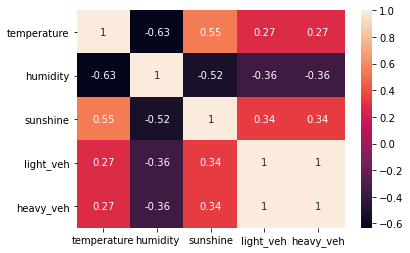

In [88]:
# Always check correlations with heatmap and pairplot
# If two variables are very correlated, think of
# (1) merging them or (2) removing one
# In this case, tghe number of heaviy and light vehicles
# are correlated
sns.heatmap(df.corr(), annot=True)

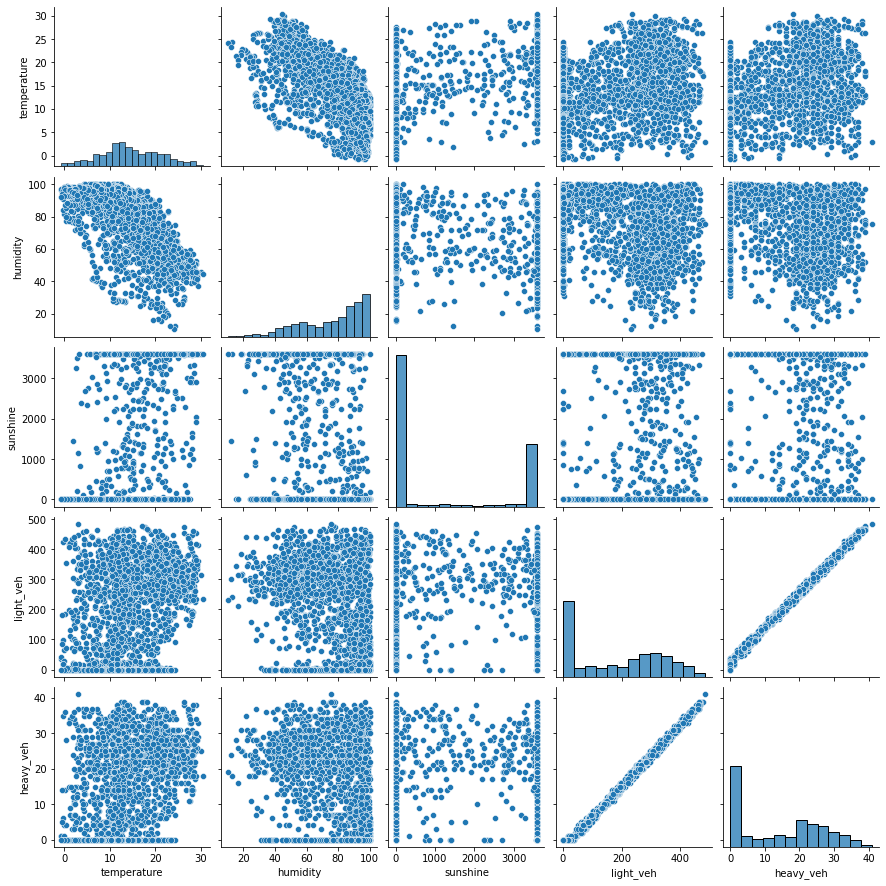

In [87]:
sns.pairplot(df)

## 3.3 Outliers